# Aula 4: Gerando textos

## Vídeo 4.1: Organizando os dados

In [1]:
import pandas as pd
import tensorflow as tf

url ='https://github.com/allanspadini/curso-tensorflow-proxima-palavra/raw/main/dados/train.zip'

df = pd.read_csv(url, header=None, names=['ClassIndex','Título','Descrição'])


df['Texto'] = df['Título'] + ' ' + df['Descrição']

2024-06-20 17:58:05.417978: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-20 17:58:06.805128: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df['Texto']

0         Wall St. Bears Claw Back Into the Black (Reute...
1         Carlyle Looks Toward Commercial Aerospace (Reu...
2         Oil and Economy Cloud Stocks' Outlook (Reuters...
3         Iraq Halts Oil Exports from Main Southern Pipe...
4         Oil prices soar to all-time record, posing new...
                                ...                        
119995    Pakistan's Musharraf Says Won't Quit as Army C...
119996    Renteria signing a top-shelf deal Red Sox gene...
119997    Saban not going to Dolphins yet The Miami Dolp...
119998    Today's NFL games PITTSBURGH at NY GIANTS Time...
119999    Nets get Carter from Raptors INDIANAPOLIS -- A...
Name: Texto, Length: 120000, dtype: object

In [3]:
import random

random.seed(42)
df_sample = df.sample(n=1000)

In [4]:
# Combinar todos os textos em um único corpus
corpus = df_sample['Texto'].tolist()

In [5]:
from tensorflow.keras.layers import TextVectorization

In [6]:
max_vocab_size = 20000
max_sequence_len = 50

In [7]:
# Tokenizar o texto
vectorizer = TextVectorization(max_tokens=max_vocab_size, output_sequence_length=max_sequence_len, output_mode='int')
# Adaptar a camada ao corpus
vectorizer.adapt(corpus)
# Convertendo os textos em sequências de tokens
tokenized_corpus = vectorizer(corpus)

2024-06-20 17:58:09.818430: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 17969352 exceeds 10% of free system memory.
2024-06-20 17:58:10.429933: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 17969352 exceeds 10% of free system memory.


In [8]:
import pickle
# Salvando a camada de vetorização
with open('vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)

In [9]:
# Criar as sequências de n-grams
input_sequences = []
for token_list in tokenized_corpus.numpy():
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

In [10]:
input_sequences

[array([1541, 1921]),
 array([1541, 1921,    9]),
 array([1541, 1921,    9,   68]),
 array([1541, 1921,    9,   68, 1204]),
 array([1541, 1921,    9,   68, 1204, 1812]),
 array([1541, 1921,    9,   68, 1204, 1812,   26]),
 array([1541, 1921,    9,   68, 1204, 1812,   26,   26]),
 array([1541, 1921,    9,   68, 1204, 1812,   26,   26,    4]),
 array([1541, 1921,    9,   68, 1204, 1812,   26,   26,    4,   21]),
 array([1541, 1921,    9,   68, 1204, 1812,   26,   26,    4,   21, 1541]),
 array([1541, 1921,    9,   68, 1204, 1812,   26,   26,    4,   21, 1541,
        1574]),
 array([1541, 1921,    9,   68, 1204, 1812,   26,   26,    4,   21, 1541,
        1574,  121]),
 array([1541, 1921,    9,   68, 1204, 1812,   26,   26,    4,   21, 1541,
        1574,  121,    6]),
 array([1541, 1921,    9,   68, 1204, 1812,   26,   26,    4,   21, 1541,
        1574,  121,    6, 3180]),
 array([1541, 1921,    9,   68, 1204, 1812,   26,   26,    4,   21, 1541,
        1574,  121,    6, 3180,  104]),


In [11]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [12]:
def prepare_sequences(sequences):
    """
    Prepara as sequências para o modelo, removendo zeros à direita, adicionando padding à esquerda, truncado sequências longas e removendo sequências repetidas.

    Args:
        sequences: Um array de sequências (listas ou arrays NumPy).

    Returns:
        Um array NumPy 2D com as sequências preparadas.
    """

    # Remover zeros à direita de cada sequência
    sequences_without_trailing_zeros = []
    for seq in sequences:
        last_nonzero_index = np.argmax(seq[::-1] != 0)
        if last_nonzero_index == 0 and seq[-1] == 0:
            sequences_without_trailing_zeros.append(np.array([0])) 
        else:
            sequences_without_trailing_zeros.append(seq[:-last_nonzero_index or None]) 

    # Remover sequências repetidas
    unique_sequences = []
    for seq in sequences_without_trailing_zeros:
        if seq.tolist() not in unique_sequences:  # Verifica se a sequência já está na lista
            unique_sequences.append(seq.tolist())  # Adiciona à lista se for única

    # Encontrar o comprimento máximo das sequências sem zeros à direita
    max_sequence_len = max(len(seq) for seq in unique_sequences)

    # Adicionar padding à esquerda para garantir o mesmo comprimento
    padded_sequences = pad_sequences(unique_sequences, maxlen=max_sequence_len, padding='pre', truncating='post')

    return padded_sequences


In [13]:
input_sequences_prepared = prepare_sequences(input_sequences)
print(input_sequences_prepared)

[[   0    0    0 ...    0 1541 1921]
 [   0    0    0 ... 1541 1921    9]
 [   0    0    0 ... 1921    9   68]
 ...
 [   0    0    0 ... 2854   20   30]
 [   0    0    0 ...   20   30 4124]
 [   0    0    0 ...   30 4124   59]]


In [14]:
# Separar as features (entradas) e o label (saída)
X = input_sequences_prepared[:,:-1]
y = input_sequences_prepared[:,-1]

In [15]:
X

array([[   0,    0,    0, ...,    0,    0, 1541],
       [   0,    0,    0, ...,    0, 1541, 1921],
       [   0,    0,    0, ..., 1541, 1921,    9],
       ...,
       [   0,    0,    0, ..., 9387, 2854,   20],
       [   0,    0,    0, ..., 2854,   20,   30],
       [   0,    0,    0, ...,   20,   30, 4124]], dtype=int32)

In [16]:
y

array([1921,    9,   68, ...,   30, 4124,   59], dtype=int32)

In [17]:
# Convertendo as saídas para uma codificação categórica
y = tf.keras.utils.to_categorical(y, num_classes=max_vocab_size)

MemoryError: Unable to allocate 106. GiB for an array with shape (708192, 20000) and data type float64

In [ ]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Vídeo 4.2: Criando e treinando o modelo

In [ ]:
# Definir o modelo
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=max_vocab_size,
        output_dim=128,
        mask_zero=False
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),  # Camada BiLSTM
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(max_vocab_size, activation='softmax')  # Use total_words em vez de 4 para o número de classes
])

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])



# Treinar o modelo
history = model.fit(X, y, epochs=100, verbose=1, batch_size=64)

Epoch 1/100
559/559 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.0280 - loss: 9.1820
Epoch 2/100
559/559 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.0455 - loss: 7.6640
Epoch 3/100
559/559 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.0487 - loss: 7.3530
Epoch 4/100
559/559 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.0542 - loss: 7.1366
Epoch 5/100
559/559 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.0611 - loss: 6.9562
Epoch 6/100
559/559 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.0716 - loss: 6.7808
Epoch 7/100
559/559 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.0806 - loss: 6.5856
Epoch 8/100
559/559 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.0874 - loss: 6.4139
Epoch 9/100
559/559 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.0954 - loss: 6.2440
Epoch 10/100
559/559 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.1028 - loss: 6.0663
Epoch 11/100
559/559 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.1152 - loss: 5.8697
Epoch 12/100
559/559 ━━━━━━━━

## Vídeo 4.3: Prevendo a próxima palavra

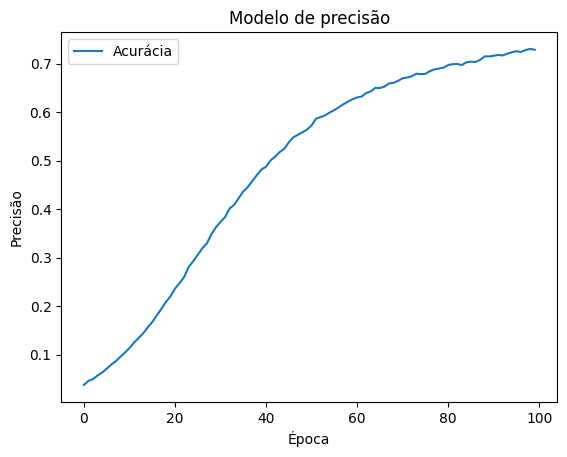

In [ ]:
import matplotlib.pyplot as plt


# Plotar a acurácia e a perda durante o treinamento
plt.plot(history.history['accuracy'])
plt.title('Modelo de precisão')
plt.ylabel('Precisão')
plt.xlabel('Época')
plt.legend(['Acurácia'], loc='upper left')
plt.show()


In [ ]:
def predict_next_words(model, vectorizer, text, max_sequence_len, top_k=3):
    """
    Prediz as próximas palavras mais prováveis em uma sequência de texto.

    Args:
        model: O modelo treinado.
        vectorizer: A camada de vetorização.
        text: O texto de entrada.
        max_sequence_len: O comprimento máximo da sequência usado na vetorização.
        top_k: O número de palavras mais prováveis a serem retornadas.

    Returns:
        As próximas palavras mais prováveis.
    """
    # Vetorizar o texto de entrada
    tokenized_text = vectorizer([text])
    
    # Remover a dimensão extra adicionada pela vetorização
    tokenized_text = np.squeeze(tokenized_text)
    
    # Adicionar padding à esquerda
    padded_text = pad_sequences([tokenized_text], maxlen=max_sequence_len, padding='pre')
    
    # Fazer a previsão
    predicted_probs = model.predict(padded_text, verbose=0)[0]  # Remove a dimensão extra adicionada pela previsão
    
    # Obter os índices dos top_k tokens com as maiores probabilidades
    top_k_indices = np.argsort(predicted_probs)[-top_k:][::-1]
    
    # Converter os tokens previstos de volta para palavras
    predicted_words = [vectorizer.get_vocabulary()[index] for index in top_k_indices]
    
    return predicted_words

In [ ]:
text = "Apple needs to make the iPhone"
text = "The FBI is warning consumers against using public phone charging stations in order to"
text = 'Making measures for a sustainable future An analyzing tool from Sandvik Coromant helps customers reduce their energy consumption and carbon emissions based on data.'

In [ ]:
predict_next_words(model, vectorizer, text, 50, top_k=3)

['site', 'bank', 'spanish']

In [ ]:
model.save('modelo_vidente.keras')